### Загрузим основные пакеты

In [1]:
import scipy as sp
import scipy.linalg as spla
import scipy.optimize as spopt
import scipy.stats as spst

import numpy as np
import numpy.linalg as npla

import statsmodels as sm
import statsmodels.api as sma

smfOLS = sma.regression.linear_model.OLS.from_formula
smfLGT = sm.discrete.discrete_model.Logit.from_formula
smfPRB = sm.discrete.discrete_model.Probit.from_formula

import seaborn as sb
import pandas as pd

import matplotlib.pyplot as plt

from inspect import signature as sig

In [2]:
# matplotlib image size and resolution
mpl_options = {"figsize":(8,8), "dpi":100}
sb.set(rc={'figure.figsize':(8,8)})

# Задача классификации

### Поговорим о методах классификации (супервайзд лернинг). На пальцах задачу можно описать как попытку разделить два облака разных цветов. Есть два качественно разных случая:

In [3]:
means = np.array([0,0])
covs = np.eye(2)
means, covs

(array([0, 0]),
 array([[1., 0.],
        [0., 1.]]))

In [4]:
size = 100
sample = np.random.multivariate_normal(means, covs, size=size)

### Облака погружены друг в друга сильно

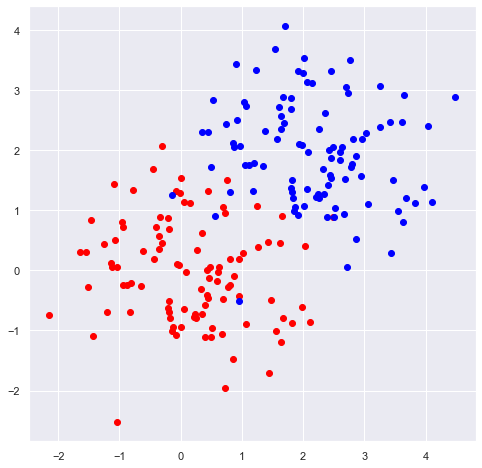

In [5]:
plt.scatter(sample[:,0], sample[:,1], color = 'red')
plt.scatter(sample[:,0]+2, sample[:,1]+2, color = 'blue')

### Облака погружены слабо

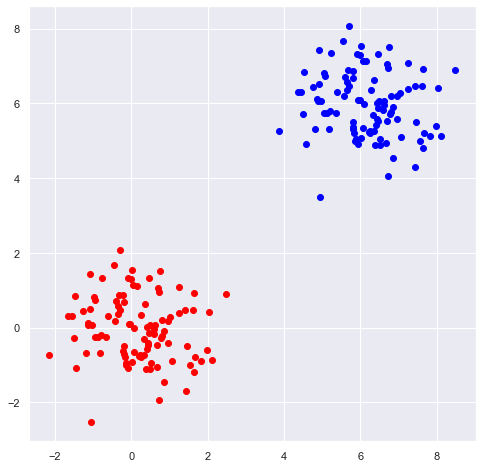

In [6]:
plt.scatter(sample[:,0], sample[:,1], color = 'red')
plt.scatter(sample[:,0]+6, sample[:,1]+6, color = 'blue')

### В экономических приложениях чаще всего попадается первый вариант - когда не существует гиперплоскости идеально разделяющей красных и синих. Но мы все же хотели бы придумать такой линейный классификатор: $$ \hat y = sgn(\alpha + \beta' x) \quad \in \{-1,1\}$$ который предсказывет "синий" то есть "1" если он больше нуля, и "красный" то есть "-1" если он меньше нуля. Геометрически это соответствует попытке провести гиперплоскость

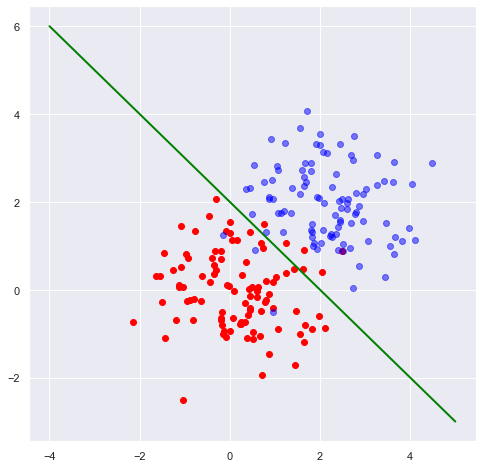

In [7]:
plt.scatter(sample[:,0], sample[:,1], color = 'red')
plt.scatter(sample[:,0]+2, sample[:,1]+2, color = 'blue', alpha = .5)
xx = np.array([-4, -2,0,2,5])
yy = 2 - xx
plt.plot(xx, yy, color = 'green', linewidth = 2)

### В данном случае прямая $y = 2 - x$ кажется убедителъным классификатором... как бы нам это автоматизировать?

### Попытка номер один: минимизируем количество ошибок первого и второго рода. То есть, минимизируем число синих точех под линией и число красных точек над линией, которая их разделяет.

$$ Utility = -Loss = \sum sgn( y_i \cdot \hat y_i ) \to \max, \quad \hat y_i = \alpha + \beta' x_i , \quad y_i, \hat y_i \in \{-1,1\}$$

### Когда знаки $\hat y_i, y_i$ противоположны, мы страдаем. Когда знаки одинаковые - радуемся. Но кажется что радость и страдания не зависят от "серьезности" ошибки первого/второго рода. Давайте добавим метрику которая бы меряла "серьезность" ошибки?

$$ Utility = -Loss = \sum F(y_i \cdot \hat y_i) \to \max, \quad \hat y_i = \alpha + \beta' x_i , \quad y_i, \hat y_i \in \{-1,1\}$$

### Какую нибудь хорошую, непрерывную, монотонную функцию $F$... и чтобы она была как то симметрична вокруг .5. Давайте попробуем что то типа $ F(z) = \frac{1}{1+e^{-z}}$ или еще лучше $ F(z) = \log \frac{1}{1+e^{-z}}$

### Плоучится что то типа:
$$ Utility = \sum \log \frac{1}{1+\exp(-y_i \cdot \hat y_i)} \to \max_{\beta}$$
### или
$$ Utility = \sum_{y_i = 1} \log \frac{1}{1+\exp(-\hat y_i)} + \sum_{y_i = -1} \log \frac{1}{1+\exp(\hat y_i)} \to \max_{\beta}$$
### Ничего не напоминает???

### Правильно это же просто ЛОГИТ!!! Логит это и есть классификатор

# Логит как классификатор

### Попытка номер два: вызовем логит как классификатор.

In [8]:
df = pd.DataFrame([])
df['X1']=np.hstack((sample[:,0], sample[:,0]+2))
df['X2']= np.hstack((sample[:,1], sample[:,1]+2))
df['Y'] = np.hstack((np.zeros(size), np.ones(size)))
df

,X1,X2,Y
0,-0.330024,0.883441,0.0
1,1.419829,0.471380,0.0
2,0.806801,0.193383,0.0
3,-0.006799,1.294156,0.0
4,0.455234,-0.133325,0.0
...,...,...,...
195,2.600709,1.830915,1.0
196,2.238258,1.271874,1.0
197,2.861465,0.530946,1.0
198,2.721707,0.049728,1.0


In [9]:
model = smfLGT("Y ~ X1 + X2", data=df)
model.fit().summary()

Optimization terminated successfully.
         Current function value: 0.122887
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      Y   No. Observations:                  200
Model:                          Logit   Df Residuals:                      197
Method:                           MLE   Df Model:                            2
Date:                Mon, 01 Mar 2021   Pseudo R-squ.:                  0.8227
Time:                        14:37:05   Log-Likelihood:                -24.577
converged:                       True   LL-Null:                       -138.63
Covariance Type:            nonrobust   LLR p-value:                 2.937e-50
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.8867      1.163     -5.060      0.000      -8.167      -3.607
X1             2.3309      0.472      4.938      0.000       1.406       3.256
X2             3.0828      0.665      4.638      0.000       1.780       4.385
==============================================================================

Possibly complete quasi-separation: A fraction 0.10 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

### Проверим что у нас получилось разделить при помощи прямой: $ 0 = \alpha + \beta ' x$ или в двумерном случае $$- x_2 = \frac{\alpha}{\beta_2} + \frac{\beta_1}{\beta_2} x_1$$

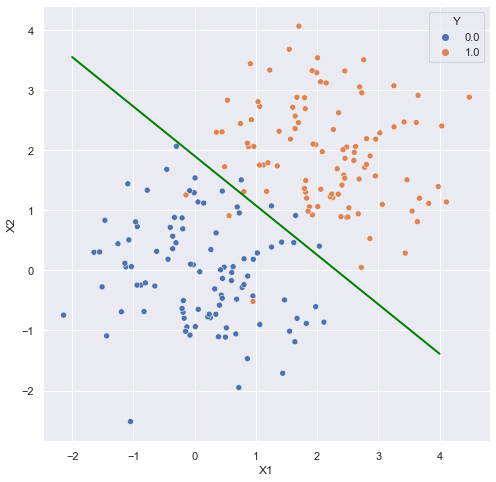

In [10]:
sb.scatterplot(x = 'X1', y='X2', data = df, hue = 'Y')
xx = np.array([-2,4])
yy = ((3.24)- xx*1.4)/1.7
plt.plot(xx, yy, color = 'green', linewidth = 2)

### Проблема логита в том, что он ожидает что облака обязательно погружены друг в друга
- погружены сильно это большая ошибка
- погруженые слабо это маленькая ошибка
- едва касаются это почти нет ошибки

### А что значит что облака далеко друг от друга?
Это значит, что в линейной формуле $$ \alpha + \beta' x + \varepsilon$$ логит будет увеличивать коэффициенты пытаясь сказать что дисперсия ошибки равна нулю, и в то же время все коэффициенты будут определены с точностью до множителя. В общем, все будет очень плохо и программа общзательно даст вам об этом знать

In [11]:
df = pd.DataFrame([])
df['X1']=np.hstack((sample[:,0], sample[:,0]+6))
df['X2']= np.hstack((sample[:,1], sample[:,1]+6))
df['Y'] = np.hstack((np.zeros(size), np.ones(size)))
model = smfLGT("Y ~ X1 + X2", data=df)
model.fit().summary()

PerfectSeparationError: Perfect separation detected, results not available

In [12]:
df = pd.DataFrame([])
df['X1']=np.hstack((sample[:,0], sample[:,0]+6))
df['X2']= np.hstack((sample[:,1], sample[:,1]+6))
df['Y'] = np.hstack((np.zeros(size), np.ones(size)))
model = smfPRB("Y ~ X1 + X2", data=df)
model.fit().summary()

         Current function value: 0.000000
         Iterations: 35


/Users/pasha/Documents/Conda/envs/py37an/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:                      Y   No. Observations:                  200
Model:                         Probit   Df Residuals:                      197
Method:                           MLE   Df Model:                            2
Date:                Mon, 01 Mar 2021   Pseudo R-squ.:                   1.000
Time:                        14:37:18   Log-Likelihood:            -1.0488e-07
converged:                      False   LL-Null:                       -138.63
Covariance Type:            nonrobust   LLR p-value:                 6.223e-61
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -11.3460   2022.172     -0.006      0.996   -3974.730    3952.038
X1             1.2032    347.655      0.003      0.997    -680.187     682.594
X2             3.0820    971.603      0.003      0.997   -1901.225    1907.389
==============================================================================

Complete Separation: The results show that there iscomplete separation.
In this case the Maximum Likelihood Estimator does not exist and the parameters
are not identified.
"""

### "Perfect separation" значит что облака сильно отделены друг от друга и коэффициенты в модели не могут быть идентифицированы с какой либо уверенностью, не говоря уже об интервалах. Конечно, можно добавить регуляризацию это формально заставит алгорим сойтись

In [ ]:
df = pd.DataFrame([])
df['X1']=np.hstack((sample[:,0], sample[:,0]+6))
df['X2']= np.hstack((sample[:,1], sample[:,1]+6))
df['Y'] = np.hstack((np.zeros(size), np.ones(size)))
model = smfLGT("Y ~ X1 + X2", data=df)
model.fit_regularized().summary()

### Однако даже с регуляризацией логит воспримет два раздельных облака как исключительно редкое явление и вообще отвратительный фит (достаточно посмотреть на интервалы), так что надо искать другую модель...